<h1> Mnist Basic</h1>

A basic classifer to recognize numbers in the MNIST dataset. This is based on the TensorFlow tutorial - but without using TensorFlow or Scikit-Learn.

```python
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)
```

Source: https://www.tensorflow.org/tutorials

<i>Written by Stephen Oman (c) 2020/2021. If you use this code, please include attribution to this GitHub repo. Code is presented as is, for illustration purposes only. Hope you learn something from it!</i>

<h2>Libraries</h2>

Load in the libraries needed for this classifer

In [1]:
import time
import numpy as np
import math
import struct

from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)

<h2>MNIST Data</h2>

MNIST is a commonly used dataset for machine learning. It contains images of hand-written digits. Each image has one digit in the range 0 to 9.

There are four files in the MNIST data set:
1. train-images-idx3-ubyte - Collection of 60,000 images, each 28x28 pixels. Each pixel has a value representing a greyscale value from 0 (white) to 255 (black).
2. train-labels-idx1-ubyte - The associated label for each of the images
3. t10k-labels-idx1-ubyte - A set of 10,000 images that should be used only for testing a model
4. t10k-images-idx3-ubyte - The corresponding labels for each of the images in the test set.

In [2]:
# replace the path to the training labels file as necessary
train_labels_file = open('mnist_data/train-labels-idx1-ubyte', 'rb')

# read in the header from the file
label_magic, label_images = struct.unpack('>LL', train_labels_file.read(8))

# create a numpy array of the labels
train_labels = np.fromfile(train_labels_file, dtype=np.uint8)

train_labels_file.close()

# now let's import the image data
train_data_file = open('mnist_data/train-images-idx3-ubyte', 'rb')

# read in the header from the file
data_magic, data_images, rows, columns = struct.unpack('>LLLL', train_data_file.read(16))

# create a numpy array of the training data
train_data = np.fromfile(train_data_file, dtype=np.uint8)
train_data = train_data / 255.0
train_data_file.close()

# now we need to read in the test data
test_labels_file = open('mnist_data/t10k-labels-idx1-ubyte', 'rb')

# read in the header from the file
label_magic, label_images = struct.unpack('>LL', test_labels_file.read(8))

# create a numpy array of the labels
test_labels = np.fromfile(test_labels_file, dtype=np.uint8)

test_labels_file.close()

# now let's import the image data
test_data_file = open('mnist_data/t10k-images-idx3-ubyte', 'rb')

# read in the header from the file
data_magic, data_images, rows, columns = struct.unpack('>LLLL', test_data_file.read(16))

# create a numpy array of the test data
test_data = np.fromfile(test_data_file, dtype=np.uint8)
test_data = test_data / 255.0
test_data_file.close()

<h2>Flatten the images</h2>

After reading in the data from the file, it is a one-dimensional array of data. We need to split this out into a 2D array, where each row is a separate image and the columns are the 784 pixels.

In [3]:
# arrange the data - this has the same effect as the flatten layer in the TensorFlow example
# we end up with a vector for each image
train_imgs = train_data.reshape(60000, 784)
test_imgs = test_data.reshape(10000, 784)

<h2>Layer 0 - ReLU Function</h2>

The first layer of the network uses the Rectified Linear Unit (ReLU) activation. In this implementation, we'll use the leaky version of the ReLU function that outputs a small negative value in the case that the input is less than zero.

In [4]:
# ReLU Activation
def relu(vector):
    epsilon = 0.1
    vector[vector<0] *= epsilon
    return(vector)

<h3>Softmax Function</h3>

see https://en.wikipedia.org/wiki/Softmax_function for details

$\sigma(\textbf{z})_{i}=\frac{e^{z_{i}}} {\sum_{j=1}^K e^{z_{j}}}$

In this function, we are assuming that <b>z</b> is a 2D matrix, each row is an instance in the mini batch.

In [5]:
# Softmax Activation
def softmax(z):
    ez = np.exp(z)
    sum_ez = np.sum(ez, axis = 0)
    sm = np.divide(ez, sum_ez)
    return (sm)

<h2>One-Hot Representation of the labels</h2>


In [6]:
#                                                        #
# The training labels use integers so we have to convert #
# them to one-hot vectors.                               #
#                                                        #

def one_hot(indexes):
    y = np.zeros((indexes.shape[0],10))
    for i in range(y.shape[0]):
        y[i][indexes[i]] = 1
    return y

<h3>Categorical Cross Entropy</h3>

Categorical Cross Entropy loss function is used when we have a lot of classes that the output could be in, only one of which is correct (i.e. an instance can only be in one class).

$-\sum_{c=0}^{M-1} y_{o,c}\verb!log!(y_{o,c})$

In this case, there are M classes and $y$ is a vector of $y_{o,c}$ probabilities. <b>$y$</b> would be calculated using a softmax function.

The Sparse version is used when the classes are numerous and the probability vector <b>p</b> would be mostly full of zeros. In this case, we can pull the correct class using it's label <b>y</b> and just calculate the cost directly from that. Note that we are using the log of the probability, so the higher the probability, the lower the cost.

$y$ is a 1D matrix, representing the collection of outputs from softmax and <b>$y$</b> is a vector of the corresponding labels.

In [7]:
def x_entropy(y, y_hat):
    return(-1 * y * np.log(y_hat))

<h2> Feedforward Network Calculations </h2>

This function will calculate the values in the network, feeding the input batch, the weights, and the labels, and then returning those values in a dictionary.

The network is straightforward enough:

* Layer 0 essentially stacks the bias signals (all ones) onto the images in the input batch (X), then multiplies it by the weights (Z0) and applies the ReLU activation function (A0).
* Layer 1 is similar, multiplying the input to the layer by the weights (Z1) and then applying the Softmax activation function (A1).
* L is the value from the loss function for each of the images.
* J is the average loss for this batch, which is the cost of the model on this set of inputs.

In [8]:
# inputs is a tensor representing a batch of images
def feedforward(inputs, weights, labels):
    
    # Layer 0
    
    bias0 = np.ones((inputs.shape[0]))
    
    X = np.vstack((bias0, np.transpose(inputs)))
    
    Z0 = np.dot(np.transpose(weights["W0"]), X)
   
    bias1 = np.ones((Z0.shape[1]))
    
    A0 = np.vstack((bias1, relu(Z0)))
    
    # Layer 1
    
    Z1 = np.dot(np.transpose(weights["W1"]), A0)
    
    A1 = softmax(Z1)
    
    L = x_entropy(np.transpose(labels), A1) # loss function
    
    J = np.average(L) # cost of this batch
    
    network = {
        "X" : X,
        "Z0" : Z0,
        "A0" : A0,
        "Z1" : Z1,
        "A1" : A1,
        "L" : L,
        "J" : J
    }
    
    return network

<h2> Backpropogation - Long Form </h2>

This is the long form of the backprop algorithm. Essentially, for every function we applied in the feedforward part, we need to work out it's derivative. These derivatives are combined using the Chain Rule.

* L_prime is the derivative of the loss function L with respect to it's input A1.
* A1_prime is the derivative of the activation function A1 (i.e. the softmax function), with respect to it's input Z1.
* Z_prime is the derivative of the summation function with respect to the weights. Since both Z0 and Z1 are the same function in the feedforward network, we can use the same function for the derivative.
* ZA_prime is an alternative derivative of the summation function, this time with respect to the input from the previous layer. This is done in order to back-propogate the error into the previous layer. Note that when we call ZA_prime during backprop, we do not include the bias signals, since any error there is not propogated backwards into the previous layer.
* A0_prime is the derivative of the activation function in layer 0, i.e. the ReLU function, with respect to summation function Z0.

These derivatives are pretty big matricies, since they are calculated by using partial derivatives. They are included here for illustration purposes only. For any decent batch size, they are going to crash the Python kernel as they are too big and take too long to process.
 

In [9]:
####################################################################
#                                                                  #
# Long form version to see all the derivative chain rule in action #
#                                                                  #
####################################################################
#                                                                  #
# Don't use this, as some of the matrices are quite large and will #
# crash the kernel, apart from taking forever to churn through it. #
#                                                                  #
####################################################################

# Backprop support functions

def L_prime(Y, A1):
    print("starting L_prime")
    dir_matrix = np.zeros((Y.shape[1],A1.shape[0] * A1.shape[1]))
    for h in range(0, Y.shape[1]):
        for i in range(0, A1.shape[0]):
            if(Y[i][h]==1):
                dir_matrix[h][i + (h * A1.shape[0])] = -1.0 / A1[i][h]
    print("finished L_prime")
    return dir_matrix

def A1_prime(A1, Z1):
    print("starting A1_prime")
    dir_matrix = np.zeros((A1.shape[0] * A1.shape[1], Z1.shape[0] * Z1.shape[1]))
    
    for h in range(0, A1.shape[1]):
        for i in range(0, A1.shape[0]):
            for j in range(0, Z1.shape[0]):
                if(i == j):
                    dir_matrix[i + (h * A1.shape[0])][j + (h * A1.shape[0])] = A1[i][h] * (1 - A1[i][h])
                else:
                    dir_matrix[i + (h * A1.shape[0])][j + (h * A1.shape[0])] = -1.0 * A1[i][h] * A1[j][h]
    print("finishing A1_prime")
    return dir_matrix

def Z_prime(Z, W, A):
    print("starting Z_prime")
    dir_matrix = np.zeros((Z.shape[0] * Z.shape[1], W.shape[0]*W.shape[1]))
    for h in range(Z.shape[1]):
        for i in range(Z.shape[0]):
            for j in range(W.shape[1]):
                for k in range(W.shape[0]):
                    if(i == j):
                        dir_matrix[i + (h * Z.shape[0])][(j*W.shape[0]) + k] = A[k][h]
    print("finishing Z_prime")
    return dir_matrix

def ZA_prime(Z, W, A):
    print("starting ZA_prime")
    dir_matrix = np.zeros((Z.shape[0] * Z.shape[1], A.shape[0] * A.shape[1]))
    
    for h in range(Z.shape[1]):
        for i in range(A.shape[1]):
            for j in range(Z.shape[0]):
                for k in range(A.shape[0]):
                    if(h == i):
                        dir_matrix[(h * Z.shape[0]) + j][(i * A.shape[0]) + k] = W[k+1][j]
    print("finishing ZA_prime")
    return dir_matrix

def A0_prime(A,Z):
    print("starting A0_prime")
    epsilon = 0.1
    dir_matrix = np.zeros((A.shape[0] * A.shape[1], Z.shape[0] * Z.shape[1]))
    for i in range(0, A.shape[1]):
        for j in range(0, A.shape[0]):
            if(Z[j][i] < 0):
                dir_matrix[(i * A.shape[0]) + j][(i * A.shape[0]) + j] = epsilon
            else:
                dir_matrix[(i * A.shape[0]) + j][(i * A.shape[0]) + j] = 1
    print("finishing A0_prime")
    return dir_matrix


# main back-propogation chain rule

def backprop(inputs, weights, network, labels):
    dLdA1 = L_prime(np.transpose(labels), network["A1"])
    
    dA1dZ1 = A1_prime(network["A1"], network["Z1"])
    
    dZ1dW1 = Z_prime(network["Z1"], weights["W1"], network["A0"])
    
    dLdZ1 = np.dot(dLdA1, dA1dZ1)
    
    dLdW1 = np.dot(dLdZ1, dZ1dW1)
    
    dJdW1 = np.sum(dLdW1, axis = 0) / inputs.shape[0]
    
    delta_W1 = 0.05 * np.transpose(dJdW1.reshape((weights["W1"].shape[1], weights["W1"].shape[0])))

    dZ1dA0 = ZA_prime(network["Z1"], weights["W1"], network["A0"][1:])
    
    dLdA0 = np.dot(dLdZ1, dZ1dA0)
    
    dA0dZ0 = A0_prime(network["A0"][1:], network["Z0"])
    
    dZ0dW0 = Z_prime(network["Z0"], weights["W0"], network["X"])
    
    dLdZ0 = np.dot(dLdA0, dA0dZ0)
    
    dLdW0 = np.dot(dLdZ0, dZ0dW0)
    
    dJdW0 = np.sum(dLdW0, axis = 0) / inputs.shape[0]
    
    delta_W0 = 0.05 * np.transpose(dJdW0.reshape((weights["W0"].shape[1], weights["W0"].shape[0])))

    return(delta_W0, delta_W1)

<h2> Backprop - Short Form </h2>

Luckily for us, with a bit of mathematical tinkering with the formulae above, we can shorten the derivative calculations and implement them without Jacobian matrices.

* layer1_prime calcualtes the derivative of the loss function L with respect to the weights in layer 1 (W1).
* layer0_prime similarly calcualtes the derivative of the loss function L with respect to the weights in layer 0 (W0).

In [10]:
#                                                        #
# Shortcut backprop functions - use these instead of the #
# longer form functions from above. Your life will be so #
# much easier.                                           #
#                                                        #

#                                                        #
# Shortcut to the whole Layer 1 derivative without doing #
# Jacobian matrix multiplication.                        #
#                                                        #

def layer1_prime(W, A, Labels, X):
    
    A_prime = np.copy(A)
    for i in range(labels.shape[0]):
        A_prime[labels[i]][i] -= 1   
    
    dir_matrix = np.dot(X, np.transpose(A_prime))

    return (dir_matrix / X.shape[1])

#                                                        #
# Shortcut to the whole Layer 0 derivative without those #
# pesky Jacobians.                                       #
#                                                        #


def layer0_prime(W1, W0, A1, Labels, X, A0):
    epsilon = 0.1
    
    A1_prime = np.copy(A1)
    for i in range(labels.shape[0]):
        A1_prime[labels[i]][i] -= 1   
        
    A0_prime = np.dot(W1, A1_prime)
    
    Z0_prime = np.copy(A0)
    Z0_prime[Z0_prime >= 0] = 1
    Z0_prime[Z0_prime <0 ] = epsilon
    Z0_prime = Z0_prime * A0_prime

    dir_matrix = np.dot(X, np.transpose(Z0_prime))
                
    return (dir_matrix / X.shape[1])

#                                                        #
# Call this function to get the gradients for weights in #
# both layers.                                           #
#                                                        #

def backprop_short(inputs, weights, network, labels):
    delta_W1 = layer1_prime(weights["W1"], network["A1"], labels, network["A0"])
    delta_W0 = layer0_prime(weights["W1"][1:], weights["W0"], network["A1"], labels, 
                            network["X"], network["A0"][1:])
    return(delta_W0, delta_W1)

<h2>Main Learning Driver</h2>

This is the controller of the feedforward and backprop functions. It starts with initialising the batch size, learning rate and weights for layer 0 and layer 1.

It then goes through the test set 5 times (epochs), each time splitting the test set into batches and submitting them to the feedforward function. Then it executes the backprop function to figure out the changes that must be made to the weights.

I've left in some print statements so that you can see the loss decreasing as the algorithm learns (these are commented out).

In [11]:
batch_size = 50

learn_rate = 0.1

weights_l0 = (2 * (np.random.random([train_imgs[0].shape[0]+1, 512]))) - 1
weights_l1 = (2 * (np.random.random([513,10]))) - 1

weights = {
    "W0" : weights_l0,
    "W1" : weights_l1
}

for epoch in range(5):
    batch_start = 0
    batch_end = batch_start + batch_size
    batch_num = 1
    
    # In the case where batch size is set to be
    # greater than the number of training images
    if(batch_end > train_imgs.shape[0]):
        batch_end = train_imgs.shape[0]
    
    while(batch_start < train_imgs.shape[0]):
        inputs = train_imgs[batch_start:batch_end]
        labels = train_labels[batch_start:batch_end]
        labels_1h = one_hot(labels)

        network = feedforward(inputs, weights, labels_1h)
        
#         if(batch_num % 100 == 0):
#             print("Epoch : ", epoch, " Batch : ", batch_num, " Loss : ", network["J"])
        
        dW0, dW1 = backprop_short(inputs, weights, network, labels)
        
        weights["W0"] = weights["W0"] - (learn_rate * dW0)
        weights["W1"] = weights["W1"] - (learn_rate * dW1)
        
        batch_start = batch_start + batch_size
        batch_end = batch_end + batch_size
        
        # check for last batch size being greater
        # than the number of remaining instances
        
        if(batch_end > train_imgs.shape[0]):
            batch_end = train_imgs.shape[0]
        batch_num = batch_num + 1
        
            
print("End of Learning with loss : ", network["J"])


End of Learning with loss :  1.367880116977625e-05


<h2>Test A Number</h2>

Here's a small section that you can use to select an image in the test set and use the algorithm's feedforward function to make an estimate of what the image represents.

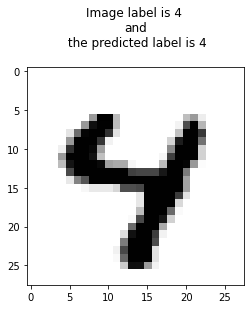

In [12]:
# Test a particular value from the test set

image = 1010    # Change this to any value in the test set

test_img = np.array([test_imgs[image]])
test_label = np.array([test_labels[image]])
test_label_1h = one_hot(test_label)

result = feedforward(test_img, weights, test_label_1h)

pixels = test_img.reshape((28, 28))
plt.imshow(pixels, cmap='gray_r')
heading = "Image label is " + str(test_label[0]) + \
    " \nand\n the predicted label is " + str(np.argmax(result["A1"])) + "\n"
plt.title(heading)
plt.show()

<h2>Metrics</h2>

Using the test set, we can calculate a whole range of metrics so see how good this basic model is:

* Total accuracy of the whole model
* Accuracy per digit
* True Positives, False Positives, True Negatives, False Negatives for each digit
* Precision, Recall, Specificity and F1 Score

Usually, a basic model such as this one will perform reasonably well, with accuracy in excess of 0.93 (meaning it will make the correct prediction in 93 attempts out of 100).

In [13]:
# Basic Metrics

# Calculate all the outputs

all_test_labels_1h = one_hot(test_labels)

test_results = feedforward(test_imgs, weights, all_test_labels_1h)

# Stats over all predictions and per digit

correct_predictions_per_digit = np.zeros((10,2))

for prediction in range(test_results["A1"].shape[1]):
    correct_predictions_per_digit[test_labels[prediction]][0] += 1
    if(np.argmax(np.transpose(test_results["A1"])[prediction]) == test_labels[prediction]):
        correct_predictions_per_digit[test_labels[prediction]][1] += 1
        
total_predictions = prediction + 1
total_correct_predictions = int(np.sum(correct_predictions_per_digit, axis = 0)[1])

stats = [{"tp":0, "fp":0, "tn":0, "fn":0} for i in range(10)]

for stat in range(10):
    for prediction in range(test_results["A1"].shape[1]):
        if(stat == test_labels[prediction]):
            # True Positives & False Negative
            if(np.argmax(np.transpose(test_results["A1"])[prediction]) == stat):
                stats[stat]["tp"] += 1
            else:
                stats[stat]["fn"] += 1
        else:
            # False Positives and True Negatives
            if(np.argmax(np.transpose(test_results["A1"])[prediction]) == stat):
                stats[stat]["fp"] += 1
            else:
                stats[stat]["tn"] += 1

print("Total predictions ", total_predictions)
print("Total correct predictions ", total_correct_predictions)
print("Overall model accuracy", total_correct_predictions / total_predictions, "\n")

print("{0:5} {1:6} {2:8} {3:8} {4:>6} {5:>6} {6:>6} {7:>6} {8:>10} {9:>8} {10:>12} {11:>8}".format(
    "Digit", "Total", "Correct", "Accuracy", "TP", "FN", "FP", "TN", 
    "Precision", "Recall", "Specificity", "F1score"))

for digit in range(10):
    total = int(correct_predictions_per_digit[digit][0])
    correct = int(correct_predictions_per_digit[digit][1])
    accuracy = correct_predictions_per_digit[digit][1] / correct_predictions_per_digit[digit][0]
    tp = stats[digit]["tp"]
    fp = stats[digit]["fp"]
    tn = stats[digit]["tn"]
    fn = stats[digit]["fn"]
    precision =  tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1score = (tp * 2) / ((tp * 2) + fp + fn)
    
    print("{0:^5} {1:5} {2:8} {3:9.5f} {4:6} {5:6} {6:6} {7:6} {8:10.5f} {9:8.5f} {10:12.5f} {11:8.5f}"
          .format(digit, total, correct, accuracy, tp, fp, tn, fn, 
                  precision, recall, specificity, f1score))

Total predictions  10000
Total correct predictions  9524
Overall model accuracy 0.9524 

Digit Total  Correct  Accuracy     TP     FN     FP     TN  Precision   Recall  Specificity  F1score
  0     980      953   0.97245    953     22   8998     27    0.97744  0.97245      0.99756  0.97494
  1    1135     1123   0.98943   1123     21   8844     12    0.98164  0.98943      0.99763  0.98552
  2    1032      946   0.91667    946     23   8945     86    0.97626  0.91667      0.99744  0.94553
  3    1010      964   0.95446    964     87   8903     46    0.91722  0.95446      0.99032  0.93547
  4     982      946   0.96334    946     65   8953     36    0.93571  0.96334      0.99279  0.94932
  5     892      864   0.96861    864    104   9004     28    0.89256  0.96861      0.98858  0.92903
  6     958      918   0.95825    918     32   9010     40    0.96632  0.95825      0.99646  0.96226
  7    1028      992   0.96498    992     32   8940     36    0.96875  0.96498      0.99643  0.96686
  